In [54]:
# 定义一个句子列表，后面会用这些句子来训练 CBOW 和 Skip-Gram 模型
sentences = ["Kage is Teacher", "Mazong is Boss", "Niuzong is Boss",
             "Xiaobing is Student", "Xiaoxue is Student",]
# 将所有句子连接在一起，然后用空格分隔成多个单词
words = ' '.join(sentences).split()
# 构建词汇表，去除重复的词
word_list = list(set(words))
# 创建一个字典，将每个词映射到一个唯一的索引
word_to_idx = {word: idx for idx, word in enumerate(word_list)}
# 创建一个字典，将每个索引映射到对应的词
idx_to_word = {idx: word for idx, word in enumerate(word_list)}
voc_size = len(word_list) # 计算词汇表的大小
print(" 词汇表：", word_list) # 输出词汇表
print(" 词汇到索引的字典：", word_to_idx) # 输出词汇到索引的字典
print(" 索引到词汇的字典：", idx_to_word) # 输出索引到词汇的字典
print(" 词汇表大小：", voc_size) # 输出词汇表大小

 词汇表： ['Student', 'Niuzong', 'Mazong', 'Kage', 'Teacher', 'is', 'Boss', 'Xiaoxue', 'Xiaobing']
 词汇到索引的字典： {'Student': 0, 'Niuzong': 1, 'Mazong': 2, 'Kage': 3, 'Teacher': 4, 'is': 5, 'Boss': 6, 'Xiaoxue': 7, 'Xiaobing': 8}
 索引到词汇的字典： {0: 'Student', 1: 'Niuzong', 2: 'Mazong', 3: 'Kage', 4: 'Teacher', 5: 'is', 6: 'Boss', 7: 'Xiaoxue', 8: 'Xiaobing'}
 词汇表大小： 9


In [55]:
# 生成 CBOW 训练数据
def create_cbow_dataset(sentences, window_size=2):
    data = []# 初始化数据
    for sentence in sentences:
        sentence = sentence.split()  # 将句子分割成单词列表
        for idx, word in enumerate(sentence):  # 遍历单词及其索引
            # 获取上下文词汇，将当前单词前后各 window_size 个单词作为周围词
            context_words = sentence[max(idx - window_size, 0):idx] \
                + sentence[idx + 1:min(idx + window_size + 1, len(sentence))]
            # 将当前单词与上下文词汇作为一组训练数据
            data.append((word, context_words))
    return data
# 使用函数创建 CBOW 训练数据
cbow_data = create_cbow_dataset(sentences)
# 打印未编码的 CBOW 数据样例（前三个）
print("CBOW 数据样例（未编码）：", cbow_data[0:3])

CBOW 数据样例（未编码）： [('Kage', ['is', 'Teacher']), ('is', ['Kage', 'Teacher']), ('Teacher', ['Kage', 'is'])]


In [62]:
# 定义 One-Hot 编码函数
import torch # 导入 torch 库
def one_hot_encoding(word, word_to_idx):    
    tensor = torch.zeros(len(word_to_idx)) # 创建一个长度与词汇表相同的全 0 张量  
    tensor[word_to_idx[word]] = 1  # 将对应词的索引设为 1
    return tensor  # 返回生成的 One-Hot 向量
# 展示 One-Hot 编码前后的数据
word_example = "Teacher"
print("One-Hot 编码前的单词：", word_example)
print("One-Hot 编码后的向量：", one_hot_encoding(word_example, word_to_idx))

One-Hot 编码前的单词： Teacher
One-Hot 编码后的向量： tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.])


In [63]:
# 定义 CBOW 模型
import torch.nn as nn # 导入 neural network
class CBOW(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(CBOW, self).__init__()
        # 从词汇表大小到嵌入大小的线性层（权重矩阵）
        self.input_to_hidden = nn.Linear(voc_size, 
                                         embedding_size, bias=False)  
        # 从嵌入大小到词汇表大小的线性层（权重矩阵）
        self.hidden_to_output = nn.Linear(embedding_size, 
                                          voc_size, bias=False)  
    def forward(self, X): # X: [num_context_words, voc_size]
        # 生成嵌入：[num_context_words, embedding_size]
        embeddings = self.input_to_hidden(X)  
        # 计算隐藏层，求嵌入的均值：[embedding_size]
        hidden_layer = torch.mean(embeddings, dim=0)  
        # 生成输出层：[1, voc_size]
        output_layer = self.hidden_to_output(hidden_layer.unsqueeze(0)) 
        return output_layer    
embedding_size = 2 # 设定嵌入层的大小，这里选择 2 是为了方便展示
cbow_model = CBOW(voc_size,embedding_size)  # 实例化 CBOW 模型
print("CBOW 模型：", cbow_model)

CBOW 模型： CBOW(
  (input_to_hidden): Linear(in_features=9, out_features=2, bias=False)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=False)
)


Epoch: 100, Loss: 2.2154650688171387
Epoch: 200, Loss: 2.206497844060262
Epoch: 300, Loss: 2.198732344309489
Epoch: 400, Loss: 2.1917077700297036
Epoch: 500, Loss: 2.185050845146179
Epoch: 600, Loss: 2.1784375667572022
Epoch: 700, Loss: 2.171562973658244
Epoch: 800, Loss: 2.1641149679819742
Epoch: 900, Loss: 2.155749042828878
Epoch: 1000, Loss: 2.146062390009562


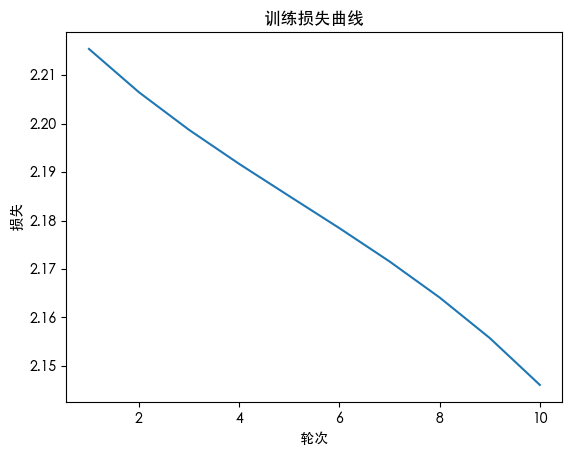

In [64]:
# 训练 Skip-Gram 类
learning_rate = 0.001 # 设置学习速率
epochs = 1000 # 设置训练轮次
criterion = nn.CrossEntropyLoss()  # 定义交叉熵损失函数
import torch.optim as optim # 导入随机梯度下降优化器
optimizer = optim.SGD(cbow_model.parameters(), lr=learning_rate)  
# 开始训练循环
loss_values = []  # 用于存储每轮的平均损失值
for epoch in range(epochs):
    loss_sum = 0 # 初始化损失值
    for target, context_words in cbow_data:
        # 将上下文词转换为 One-Hot 向量并堆叠
        X = torch.stack([one_hot_encoding(word, word_to_idx) for word in context_words]).float() 
        # 将目标词转换为索引值
        y_true = torch.tensor([word_to_idx[target]], dtype=torch.long) 
        y_pred = cbow_model(X)  # 计算预测值
        loss = criterion(y_pred, y_true)  # 计算损失
        loss_sum += loss.item() # 累积损失
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
    if (epoch+1) % 100 == 0: # 输出每 100 轮的损失，并记录损失
      print(f"Epoch: {epoch+1}, Loss: {loss_sum/len(cbow_data)}")  
      loss_values.append(loss_sum / len(cbow_data))

# 设置中文显示
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Heiti TC'  # 或者 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 绘制二维词向量图
# plt.rcParams["font.family"]=['SimHei'] # 用来设定字体样式
# plt.rcParams['font.sans-serif']=['SimHei'] # 用来设定无衬线字体样式
# plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
plt.plot(range(1, epochs//100 + 1), loss_values) # 绘图
plt.title(' 训练损失曲线 ') # 图题
plt.xlabel(' 轮次 ') # X 轴 Label
plt.ylabel(' 损失 ') # Y 轴 Label
plt.show() # 显示图

In [65]:
# 输出 Skip-Gram 习得的词嵌入
print("Skip-Gram 词嵌入：")
for word, idx in word_to_idx.items(): # 输出每个词的嵌入向量
 print(f"{word}: {cbow_model.input_to_hidden.weight[:,idx].detach().numpy()}")

Skip-Gram 词嵌入：
Student: [-0.24036586 -0.2045379 ]
Niuzong: [-0.3788509   0.12834781]
Mazong: [0.02807243 0.10757022]
Kage: [-0.07682699  0.20147766]
Teacher: [0.38010034 0.4850631 ]
is: [ 0.09662779 -0.00300276]
Boss: [-0.18364577 -0.5135584 ]
Xiaoxue: [ 0.26765233 -0.00763839]
Xiaobing: [-0.29274327 -0.23392908]


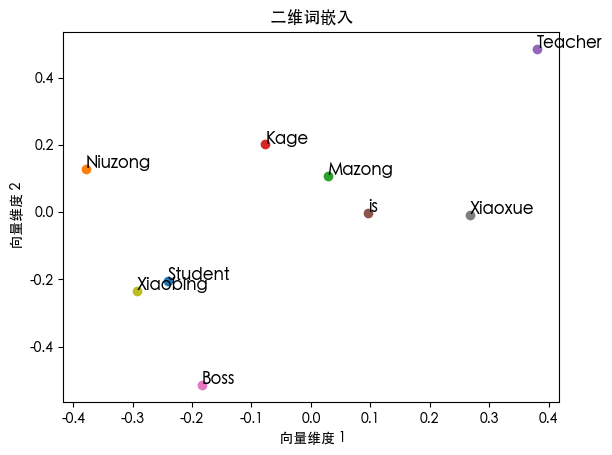

In [66]:
fig, ax = plt.subplots() 
for word, idx in word_to_idx.items():
    # 获取每个单词的嵌入向量
    vec = cbow_model.input_to_hidden.weight[:,idx].detach().numpy() 
    ax.scatter(vec[0], vec[1]) # 在图中绘制嵌入向量的点
    ax.annotate(word, (vec[0], vec[1]), fontsize=12) # 点旁添加单词标签
plt.title(' 二维词嵌入 ') # 图题
plt.xlabel(' 向量维度 1') # X 轴 Label
plt.ylabel(' 向量维度 2') # Y 轴 Label
plt.show() # 显示图